In [16]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.20.0


# Classificação de Breast Cancer

## Carregar dados

In [17]:
breast_cancer =  load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target        # rótulos (0, 1, 2)

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)
print("Classes:", breast_cancer.target_names)


Formato de X: (569, 30)
Formato de y: (569,)
Classes: ['malignant' 'benign']


## EDA

### Visualizar amostras dataset

In [18]:
# Criar um DataFrame com os dados e nomes das colunas
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

# Adicionar a coluna das classes (targets)
df["target"] = breast_cancer.target

# Mostrar as 10 primeiras linhas
df.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


### Visualizar distribuição de classes

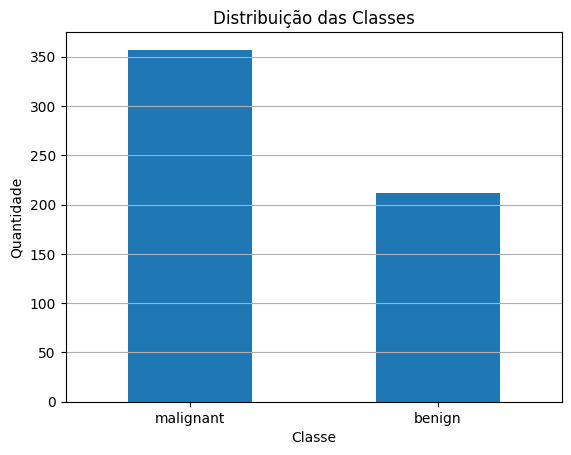

In [19]:
df['target'].value_counts().plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Distribuição das Classes')
plt.xticks(ticks=[0, 1], labels=breast_cancer.target_names, rotation=0)
plt.grid(axis='y')
plt.show()

## Pré-processar dados

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,               # X = atributos (features), y = rótulos (classes)
    test_size=0.2,      # 20% dos dados serão usados para teste
    random_state=42,    # Garante reprodutibilidade: a divisão será sempre a mesma
    stratify=y          # Mantém a proporção das classes iguais nos conjuntos de treino e teste
)

print("Dimensões dos conjuntos de treino e teste:")
print("Treino:", X_train.shape, y_train.shape)
print("Teste :", X_test.shape, y_test.shape)

print("Distribuição das classes no conjunto de treino antes do balanceamento:", np.bincount(y_train))
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("Distribuição das classes no conjunto de treino após o balanceamento:", np.bincount(y_train_bal))

print("Antes do balanceamento:", np.bincount(y_train))
print("Depois do balanceamento:", np.bincount(y_train_bal))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\nAntes da padronização (StandardScaler):")
print("Min: ", X_train.min())
print("Max: ", X_train.max())

print("\nApós a padronização (StandardScaler):")
print("Min: ", X_train_scaled.min())
print("Max: ", X_train_scaled.max())

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("\nVariância explicada pelos componentes principais:", pca.explained_variance_ratio_)
print("Soma da variância explicada:", pca.explained_variance_ratio_.sum())

Dimensões dos conjuntos de treino e teste:
Treino: (455, 30) (455,)
Teste : (114, 30) (114,)
Distribuição das classes no conjunto de treino antes do balanceamento: [170 285]
Distribuição das classes no conjunto de treino após o balanceamento: [285 285]
Antes do balanceamento: [170 285]
Depois do balanceamento: [285 285]

Antes da padronização (StandardScaler):
Min:  0.0
Max:  3432.0

Após a padronização (StandardScaler):
Min:  -2.715107359251433
Max:  11.658389001118913

Variância explicada pelos componentes principais: [0.44413492 0.18944618 0.09543356 0.06724689 0.0551769  0.03934534
 0.02181766]
Soma da variância explicada: 0.9126014634880432


## Criar o modelo

In [21]:
# Modelo MLP para breast_cancer
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train))

model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,554 (6.07 KB)

 Trainable params: 1,554 (6.07 KB)

 Non-trainable params: 0 (0.00 B)

## Treinar o modelo

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',    # or 'val_accuracy'
    patience=10,           # epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    verbose=1,
    callbacks=[early_stop] # add callback here
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8791 - loss: 0.4293 - val_accuracy: 0.9341 - val_loss: 0.2582
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9588 - loss: 0.1794 - val_accuracy: 0.9451 - val_loss: 0.1454
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9698 - loss: 0.1143 - val_accuracy: 0.9670 - val_loss: 0.1018
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9780 - loss: 0.0868 - val_accuracy: 0.9670 - val_loss: 0.0815
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0722 - val_accuracy: 0.9670 - val_loss: 0.0690
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0623 - val_accuracy: 0.9670 - val_loss: 0.0627
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0561 - val_accuracy: 0.9670 - val_loss: 0.0542
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0507 - val_accuracy: 0.9780 - v

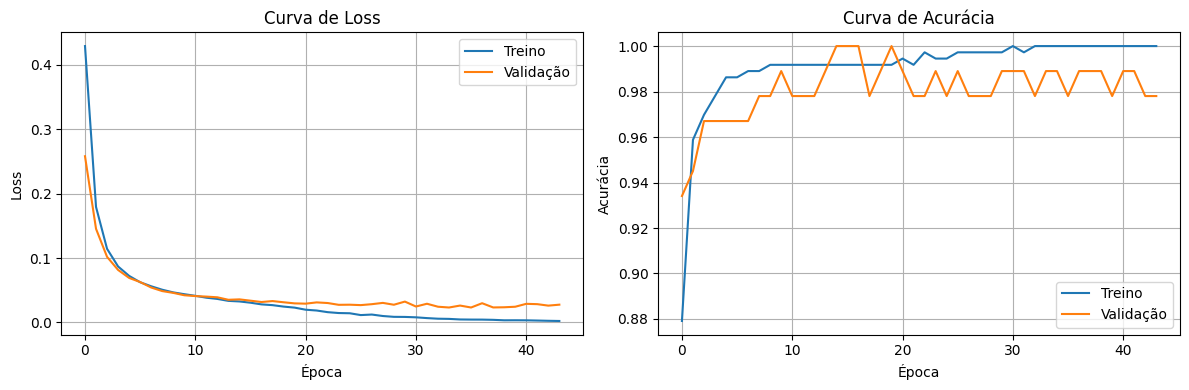

In [23]:
# Plotar curvas de treinamento (loss e acurácia) lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axs[0].plot(history.history['loss'], label='Treino')
axs[0].plot(history.history['val_loss'], label='Validação')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Loss')
axs[0].set_title('Curva de Loss')
axs[0].legend()
axs[0].grid(True)

# Acurácia
axs[1].plot(history.history['accuracy'], label='Treino')
axs[1].plot(history.history['val_accuracy'], label='Validação')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Acurácia')
axs[1].set_title('Curva de Acurácia')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Avaliação

In [24]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"Acurácia no conjunto de teste: {test_acc:.4f}")
print(f"Loss no conjunto de teste    : {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Acurácia no conjunto de teste: 0.9561
Loss no conjunto de teste    : 0.1670


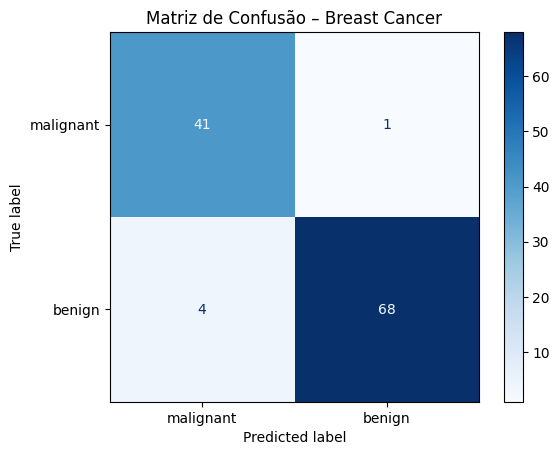

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breast_cancer.target_names)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão – Breast Cancer")
plt.show()

In [26]:
report_dict = classification_report(y_test, y_pred, target_names=breast_cancer.target_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
display(df_report)

,precision,recall,f1-score,support
malignant,0.911111,0.976190,0.942529,42.00000
benign,0.985507,0.944444,0.964539,72.00000
accuracy,0.956140,0.956140,0.956140,0.95614
macro avg,0.948309,0.960317,0.953534,114.00000
weighted avg,0.958098,0.956140,0.956430,114.00000


## Salvar o modelo

In [27]:
# Salvar modelo Keras
model.save("modelo_breast_cancer_mlp.keras")
print("Modelo salvo no formato Keras (.keras)")

Modelo salvo no formato Keras (.keras)


## Converter para TF Lite

In [28]:

# Converter para TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Salvar modelo TFLite
with open("./output/breast_cancer_mlp_float.tflite", "wb") as f:
    f.write(tflite_model)

print("Modelo TFLite (float32) gerado: breast_cancer_mlp_float.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpfbpgq_a4/assets


INFO:tensorflow:Assets written to: /tmp/tmpfbpgq_a4/assets


Saved artifact at '/tmp/tmpfbpgq_a4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132507395929488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508040624656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507395928144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507395925840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507395927568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507395926032: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelo TFLite (float32) gerado: breast_cancer_mlp_float.tflite


W0000 00:00:1764938801.708964   61957 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764938801.708984   61957 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-05 09:46:41.709162: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfbpgq_a4
2025-12-05 09:46:41.709518: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-05 09:46:41.709523: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpfbpgq_a4
2025-12-05 09:46:41.712148: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-05 09:46:41.730023: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpfbpgq_a4
2025-12-05 09:46:41.736137: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 26978 microseconds.


## Carregar modelo Lite

In [29]:

# Nomes dos arquivos
keras_file = "./output/modelo_iris_mlp.keras"
tflite_file = "./output/iris_mlp_float.tflite"
header_file = "./output/iris_mlp_float.h"
tflite_rebuilt = "./output/iris_mlp_float_2.tflite"

# Mostrar tamanhos dos arquivos
for file in [keras_file, tflite_file]:
    if os.path.exists(file):
        size = os.path.getsize(file) / 1024
        print(f"{file}: {size:.2f} KB")
    else:
        print(f"{file} não encontrado.")

# Gerar header C do modelo TFLite
os.system(f"xxd -i {tflite_file} > {header_file}")

# Mostrar primeiras linhas do header
with open(header_file, "r") as f:
    for _ in range(20):
        print(f.readline().strip())

# Reconstruir o modelo TFLite a partir do header C
try:
    with open(header_file, "r") as f:
        h = f.read()
    matches = re.findall(r'0x[0-9A-Fa-f]+', h)
    data = bytes(int(x, 16) for x in matches)
    with open(tflite_rebuilt, "wb") as f:
        f.write(data)
    print("Modelo TFLite reconstruído salvo em:", tflite_rebuilt)
except Exception as e:
    print("Erro ao reconstruir o modelo TFLite:", e)

./output/modelo_iris_mlp.keras não encontrado.
./output/iris_mlp_float.tflite não encontrado.




















Modelo TFLite reconstruído salvo em: ./output/iris_mlp_float_2.tflite


xxd: ./output/iris_mlp_float.tflite: No such file or directory


## Avaliar modelo Lite

/home/matheus/Documentos/Meus Codes/tarefa25_IA3_embarcatech/.venv/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


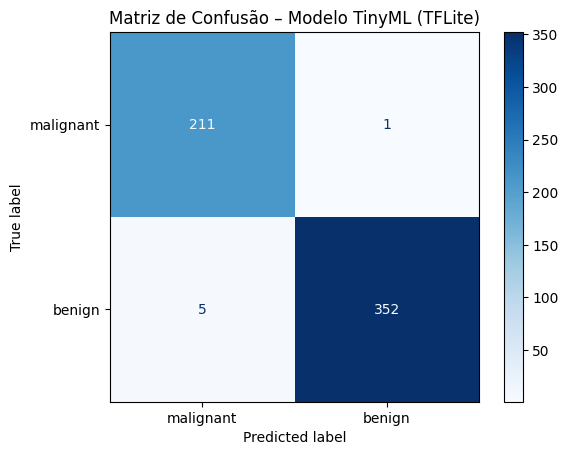

In [30]:
# Carregar dataset Breast Cancer
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# Normalizar os dados (igual ao treinamento do modelo)
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Carregar modelo TFLite reconstruído
tflite_model_path = "./output/breast_cancer_mlp_float.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fazer predições
y_pred = []
for x_sample in X_norm:
    x_input = np.expand_dims(x_sample, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]["index"], x_input)
    interpreter.invoke()
    out = interpreter.get_tensor(output_details[0]["index"])
    y_pred.append(np.argmax(out))

y_pred = np.array(y_pred)

# Matriz de confusão
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breast_cancer.target_names)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão – Modelo TinyML (TFLite)")
plt.show()